In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt

# Function to build the SegNet model
def build_segnet(input_shape=(256, 256, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=2)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=2)(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=2)(x)

    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=2)(x)

    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    model = models.Model(inputs, outputs, name="SegNet")
    return model

# Preprocessing the data and Data Generator class
image_path = "/kaggle/input/flood-area-segmentation/Image"
mask_path = "/kaggle/input/flood-area-segmentation/Mask"

input_shape = (256, 256)  
batch_size = 16

class DataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size, target_size):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_masks = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        masks = []

        for image_name, mask_name in zip(batch_images, batch_masks):
            # Load and preprocess images
            image = load_img(os.path.join(self.image_dir, image_name), target_size=self.target_size)
            image = img_to_array(image) / 255.0  # Normalize
            images.append(image)

            # Load and preprocess masks
            mask = load_img(os.path.join(self.mask_dir, mask_name), color_mode="grayscale", target_size=self.target_size)
            mask = img_to_array(mask) / 255.0  # Normalize
            masks.append(mask)

        return np.array(images), np.array(masks)

# Initialize Data Generators
train_generator = DataGenerator(image_path, mask_path, batch_size=batch_size, target_size=input_shape)

# Build the SegNet model
model = build_segnet(input_shape=(256, 256, 3), num_classes=1)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 100
history = model.fit(train_generator, epochs=epochs)

# Save the model in .keras format
model_save_path = "/kaggle/working/segnet_model.keras"
model.save(model_save_path)
print(f"Trained model saved at {model_save_path}")


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 585ms/step - accuracy: 0.5594 - loss: 0.7851
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 329ms/step - accuracy: 0.7742 - loss: 0.4943
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 0.7701 - loss: 0.4752
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/step - accuracy: 0.8021 - loss: 0.4310
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/step - accuracy: 0.7995 - loss: 0.4278
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.8040 - loss: 0.4267
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.8030 - loss: 0.4169
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - accuracy: 0.8123 - loss: 0.4031
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.8279 - loss: 0.3847
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 331ms/step - accuracy: 0.8199 - loss: 0.3816
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - accuracy: 0.8224 - loss: 0.3841
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━

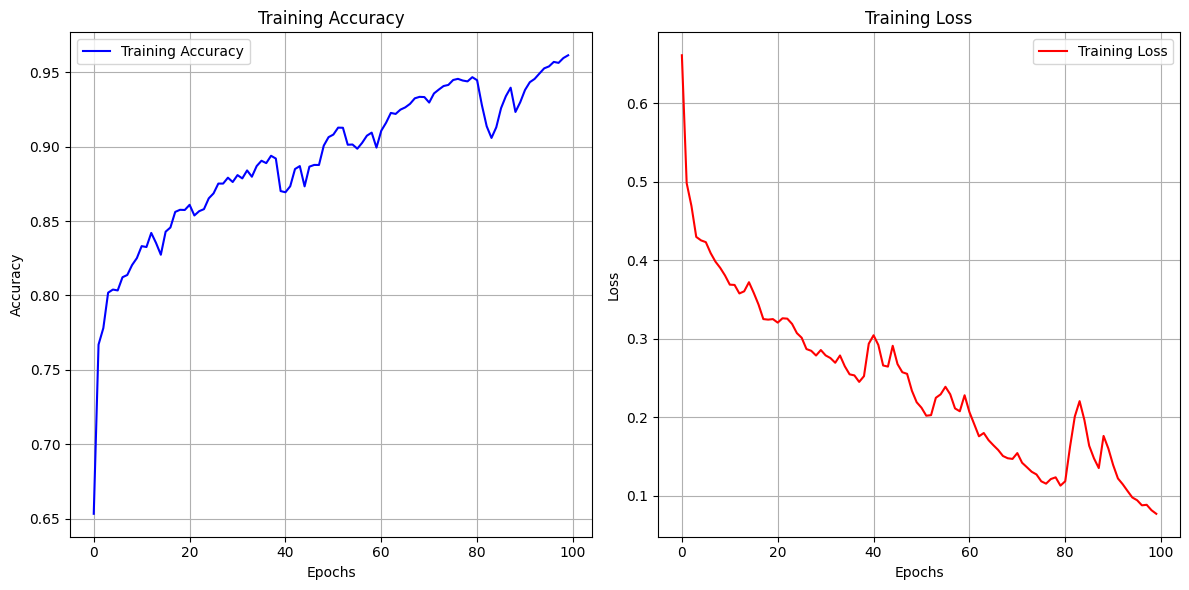

In [7]:
import matplotlib.pyplot as plt

# Extracting accuracy and loss data from the history object
history_dict = history.history
train_loss = history_dict['loss']
train_accuracy = history_dict['accuracy']

# Plotting the accuracy
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_accuracy, label="Training Accuracy", color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss, label="Training Loss", color='red')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


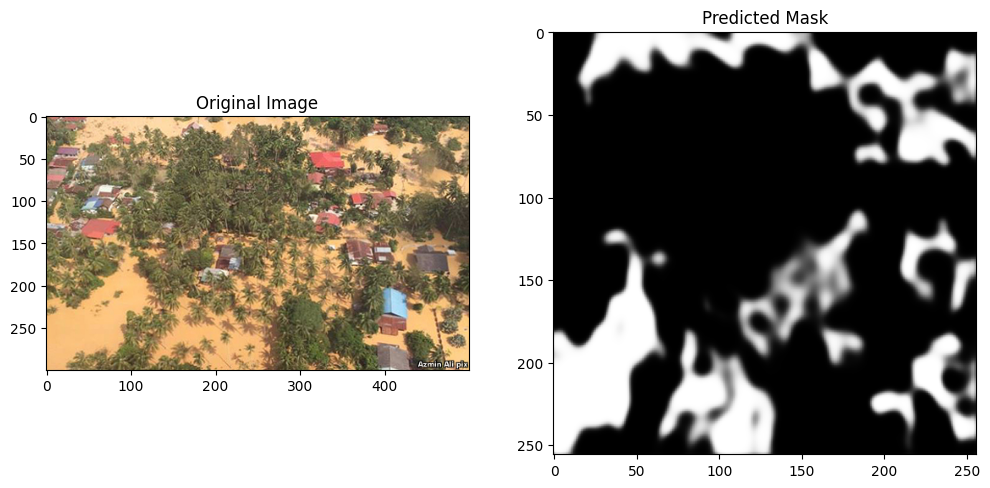

In [9]:
# Load the trained model
from tensorflow.keras.models import load_model

model = load_model("/kaggle/working/segnet_model.keras")

# Predict on a new image
def predict_segmentation(model, image_path, target_size=(256, 256)):
    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    prediction = model.predict(image_array)[0]  # Remove batch dimension
    return prediction

# Example: Predict on an image
test_image_path = "/kaggle/input/flood-area-segmentation/Image/1.jpg"
predicted_mask = predict_segmentation(model, test_image_path)

# Visualize prediction
original_image = load_img(test_image_path)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask.squeeze(), cmap="gray")  # Remove single color channel

plt.show()
